# Final Project - A/B Testing
You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

- Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.

- Purpose of the test: testing changes related to the introduction of an improved recommendation system

### Explore the data

In [1]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import math as mth




In [2]:
try:
    marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv') 
except:
    marketing = pd.read_csv('/Users/tzipimeyer/Documents/Final Project/ab_project_marketing_events_us.csv')

In [3]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
marketing = marketing.sort_values(by='start_dt')

In [5]:
try:
    users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
except:
    users = pd.read_csv('/Users/tzipimeyer/Documents/Final Project/final_ab_new_users_upd_us.csv')

In [6]:
users['first_date'] = pd.to_datetime(users['first_date'])

In [7]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
users.duplicated().sum()

0

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [10]:
try:
    events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
except:
    events = pd.read_csv('/Users/tzipimeyer/Documents/Final Project/final_ab_events_upd_us.csv')

In [11]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events['event_date'] = pd.DatetimeIndex(events['event_dt']).date

In [12]:
events.head()

,user_id,event_dt,event_name,details,event_date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
 4   event_date  423761 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.2+ MB


In [14]:
events.duplicated().sum()

0

In [15]:
events['details'].value_counts()

4.99      44579
9.99       9158
99.99      5405
499.99     1172
Name: details, dtype: int64

In [16]:
# Studying amount of missing values in 'details' column

events['details'].isna().sum()

363447

In [17]:
events[(events['details'].isna()) & (events['event_name']=='purchase')]

,user_id,event_dt,event_name,details,event_date


It seems the missing values in events are only present on events that are not purchases, which makes sense, since this column has the order total in USD for purchase events

In [18]:
try:
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
except:
    participants = pd.read_csv('/Users/tzipimeyer/Documents/Final Project/final_ab_participants_upd_us.csv')

In [19]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [20]:
participants.duplicated().sum()


0

### Exploratory Data Analysis

In [21]:
# Study min and max dates of events

users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [22]:
late_users = users[users['first_date']>'2020-12-21']
late_users

,user_id,first_date,region,device
22757,5815F7ECE74D949F,2020-12-22,CIS,PC
22758,32EAEA5E903E3BC1,2020-12-22,N.America,Android
22759,9DF7A3C46487EF0B,2020-12-22,EU,Android
22760,ADE98C6440423287,2020-12-22,EU,iPhone
22761,5A5833D3AEA75255,2020-12-22,N.America,PC
...,...,...,...,...
32118,165AFCBF42C043F8,2020-12-23,EU,PC
32119,54E7F36C0E976E24,2020-12-23,EU,Android
32120,7E43EB2E03A33E78,2020-12-23,EU,PC
32121,B8B679DEE9F2CA06,2020-12-23,EU,PC


In [23]:
participants[participants['ab_test']=='recommender_system_test']['user_id'].isin(late_users['user_id'])

0       False
1       False
2       False
3       False
4       False
        ...  
3670    False
3671    False
3672    False
3673    False
3674    False
Name: user_id, Length: 3675, dtype: bool

- The supposed date when they stopped taking up new users was 2020-12-21, but the max first_date is 2020-12-23. 
- Fortunately, none of these user_id's became participants of the test!


In [24]:
#Checking amount of unique users and proportions of A/B groups from both tests

participants.groupby(['group', 'ab_test'])['user_id'].nunique().reset_index().sort_values(by='ab_test')

,group,ab_test,user_id
0,A,interface_eu_test,5467
2,B,interface_eu_test,5383
1,A,recommender_system_test,2747
3,B,recommender_system_test,928


In [25]:
# Checking whether there are users who went to more than one <A/B> group in the same test

ab_visitors = participants.groupby(['user_id', 'ab_test'])['group'].nunique().reset_index()
ab_visitors[ab_visitors['group']>1]

,user_id,ab_test,group


Thankfully there are no users who went to the same group within the same test

In [26]:
# Unique users that went into the 'recommender_system_test' test

recommender_system_test = participants[participants['ab_test']=='recommender_system_test']
recommender_system_test['user_id'].nunique()

3675

In [27]:
# Unique users that went into the 'interface_eu_test' test

interface_eu_test = participants[participants['ab_test']=='interface_eu_test']
interface_eu_test['user_id'].nunique()

10850

In [28]:
# Investigating if there are users who went to both tests

two_tests_users = participants.groupby('user_id')['ab_test'].nunique().reset_index()
two_tests_users[two_tests_users['ab_test']==2]

,user_id,ab_test
1,001064FEAAB631A1,2
8,00341D8401F0F665,2
23,0082295A41A867B5,2
38,00E68F103C66C1F7,2
41,00EFA157F7B6E1C4,2
...,...,...
13576,FEA0C585A53E7027,2
13582,FEC0BCA6C323872F,2
13605,FF2174A1AA0EAD20,2
13610,FF44696E39039D29,2


In [29]:
# Making sure the 'recommender_system_test' audience is made of only users from the EU region

recommender_system_test_users = recommender_system_test.merge(users, on='user_id')
recommender_system_test_users['region'].value_counts()

EU           3481
N.America     119
APAC           45
CIS            30
Name: region, dtype: int64

In [30]:
# Checking % of EU users that went to the 'recommender_system_test' test

recommender_system_test_users[recommender_system_test_users['region']=='EU']['user_id'].nunique()/users[users['region']=='EU']['user_id'].nunique()

0.08021476633791133

**Problems Found**

- The real number of participants is 3675, however, the expected number of test participants is 6000
- Only 8% of EU users went into the test, not 15%, as expected
- The proportion of participants in groups A/B in recommender_system_test is about 30/70, which is much more than 1%. (The groups should be split 50/50. It seems they did not run an A/A test which could've helped prevent this.)
- Within the same tests, there seem to be no users who went to both A and B groups, but there are 887 users who went to more than one test, not sure this is a problem
- The test was supposed to include 15% of the new users from the EU region, but users from other regions went in there as well.



In [31]:
# Filtering the participants data pertaining only to users who participated in the test we're testing

participants_recommender = participants[participants['ab_test']=='recommender_system_test']
participants_recommender

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


In [32]:
# Filtering the events data that pertains only to the users who participated in the test 'recommender_system_test'

events_recommender = events[events['user_id'].isin(participants_recommender['user_id'])]
events_recommender

,user_id,event_dt,event_name,details,event_date
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07
...,...,...,...,...,...
423683,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,2020-12-29
423702,96BDD55846D1F7F6,2020-12-29 16:53:42,login,NaN,2020-12-29
423711,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN,2020-12-29
423725,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN,2020-12-30


In [33]:
# Creating a column of 'days since event' 
# Filtering out events that happened within more 14 days of sign-up & those that happened after the test's end date 2021-01-01

users_events_recommender = events_recommender.merge(users, on='user_id')
users_events_recommender['event_date'] = pd.to_datetime(users_events_recommender['event_date'])
users_events_recommender['days_since_event'] = users_events_recommender['event_date'] - users_events_recommender['first_date']
users_events_recommender = users_events_recommender[(users_events_recommender['days_since_event'] <= '14 days')|(users_events_recommender['event_date']<='2020-01-01')]
users_events_recommender = users_events_recommender.merge(participants_recommender[['user_id', 'group']], on='user_id')
users_events_recommender


,user_id,event_dt,event_name,details,event_date,first_date,region,device,days_since_event,group
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,0 days,A
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,2020-12-07,EU,Android,2 days,A
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,2020-12-07,EU,Android,0 days,A
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08,2020-12-07,EU,Android,1 days,A
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09,2020-12-07,EU,Android,2 days,A
...,...,...,...,...,...,...,...,...,...,...
23357,1E6B9298415AA97A,2020-12-21 18:20:12,login,NaN,2020-12-21,2020-12-21,N.America,Android,0 days,B
23358,1E6B9298415AA97A,2020-12-22 03:22:34,login,NaN,2020-12-22,2020-12-21,N.America,Android,1 days,B
23359,1E6B9298415AA97A,2020-12-23 11:34:53,login,NaN,2020-12-23,2020-12-21,N.America,Android,2 days,B
23360,1E6B9298415AA97A,2020-12-24 18:45:58,login,NaN,2020-12-24,2020-12-21,N.America,Android,3 days,B


In [34]:
# Study conversion at different stages of the funnel

funnel = users_events_recommender.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
funnel['users%_a'] = funnel['A']/len(participants[(participants['ab_test']=='recommender_system_test')&(participants['group']=='A')])
funnel['users%_b'] = funnel['B']/len(participants[(participants['ab_test']=='recommender_system_test')&(participants['group']=='B')])
funnel = funnel.reindex([0,2,1,3])
funnel

group,event_name,A,B,users%_a,users%_b
0,login,2747,927,1.000000,0.998922
2,product_page,1780,523,0.647980,0.563578
1,product_cart,824,255,0.299964,0.274784
3,purchase,872,256,0.317437,0.275862


- Both groups had more users in the purchase stage than in the product_cart stage
- Number of events per user distributed more or less equally amongst both groups

In [35]:
# Inspecting revenue per day by group 

pd.options.mode.chained_assignment = None 

orders = users_events_recommender[users_events_recommender['event_name']=='purchase']
orders = orders[['user_id', 'group', 'event_date', 'details']]
orders = orders.rename(columns={'details': 'revenue'})

orders_a = orders[orders['group']=='A'].sort_values(by='event_date')
orders_a  = orders_a.groupby('event_date')['revenue'].sum().reset_index()
orders_a

,event_date,revenue
0,2020-12-07,1214.54
1,2020-12-08,779.63
2,2020-12-09,1369.49
3,2020-12-10,1329.54
4,2020-12-11,1099.58
5,2020-12-12,879.62
6,2020-12-13,399.65
7,2020-12-14,3423.56
8,2020-12-15,3443.54
9,2020-12-16,4588.49


In [36]:
orders_b = orders[orders['group']=='B'].sort_values(by='event_date')
orders_b  = orders_b.groupby('event_date')['revenue'].sum().reset_index()
orders_b

,event_date,revenue
0,2020-12-07,704.41
1,2020-12-08,494.65
2,2020-12-09,419.60
3,2020-12-10,639.74
4,2020-12-11,94.84
5,2020-12-12,324.75
6,2020-12-13,1429.73
7,2020-12-14,779.66
8,2020-12-15,1459.68
9,2020-12-16,1564.47


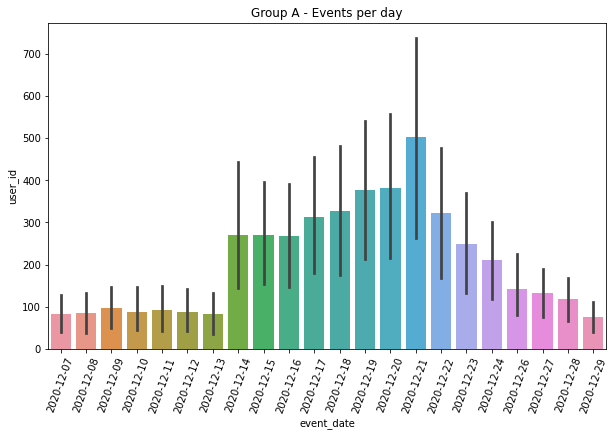

In [37]:
# How is the number of events distributed among days?

plt.figure(figsize=(10,6))
plt.xticks(rotation=70)
events_per_day_a = users_events_recommender[users_events_recommender['group']=='A'].groupby(['event_name','event_date'])['user_id'].nunique().reset_index()
events_per_day_a['event_date'] = events_per_day_a['event_date'].dt.date
sns.barplot(data=events_per_day_a, x='event_date', y='user_id').set(title='Group A - Events per day')
plt.show()


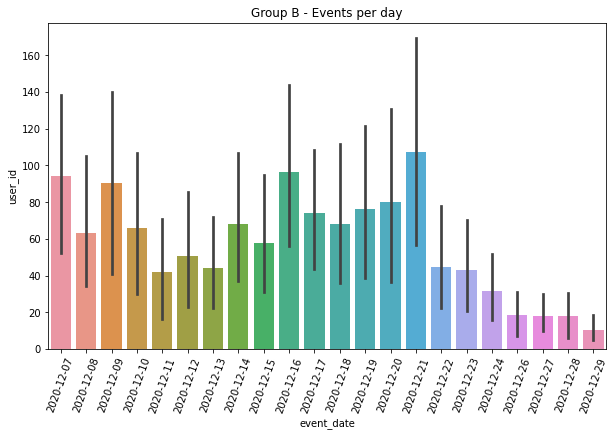

In [38]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=70)
events_per_day_b = users_events_recommender[users_events_recommender['group']=='B'].groupby(['event_name','event_date'])['user_id'].nunique().reset_index()
events_per_day_b['event_date'] = events_per_day_b['event_date'].dt.date
sns.barplot(data=events_per_day_b, x='event_date', y='user_id').set(title='Group B - Events per day')
plt.show()

In [39]:
marketing

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


**Findings**

- Both groups have different trends until 12/21, when both peak, and start decreasing at almost the same rate 
- Group A starts lower than Group A, with a growth trend that peaks on 21/12, which starts decreasing right after that
- Group B starts higher, with a decline that starts growing at around 14/12 and peaks at 21/12, decreasing sharply right after
- None of the marketing campaigns can explain the events peak that happens on 12/21, the only thing that could explain it is the test's end date which happened on the same date
- There is not a clear overlap of dates between the events per day and marketing events, except for the 'Christmas & New Year Promo', which in any case, doesn't seem to be working that great because instead of a growth trend, we see a decreasing trend from 2020-12-25	onwards

### Testing the Hypotheses

#### Creating Samples

In [40]:
# Visualizing number of unique users per event, per group

merged_events = users_events_recommender.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
merged_events

group,event_name,A,B
0,login,2747,927
1,product_cart,824,255
2,product_page,1780,523
3,purchase,872,256


In [41]:
conversion_a = merged_events['A'][3]/merged_events['A'][0]
conversion_b = merged_events['B'][3]/merged_events['A'][0]

In [42]:
print('Group A conversion:',conversion_a)
print('Group B conversion:',conversion_b)

Group A conversion: 0.3174372042227885
Group B conversion: 0.09319257371678194


Conversion for Group B is well below that of Group A

In [43]:
# Creating a table with total sample by filtering out all the test's conditions

total_sample = participants_recommender.merge(users[['first_date', 'user_id']], on='user_id')
total_sample = total_sample.merge(events[['user_id', 'event_name', 'event_date']], on='user_id')
total_sample['event_date'] =  pd.to_datetime(total_sample['event_date'])
total_sample['days_since_event'] = total_sample['event_date'] - total_sample['first_date']
total_sample = total_sample[(total_sample['days_since_event'] <= '14 days')|(total_sample['event_date']<='2020-01-01')]
total_sample['user_id'].nunique()

3675

In [44]:
total_sample

,user_id,group,ab_test,first_date,event_name,event_date,days_since_event
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,purchase,2020-12-07,0 days
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,product_cart,2020-12-07,0 days
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,product_page,2020-12-07,0 days
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,login,2020-12-07,0 days
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,product_page,2020-12-20,0 days
...,...,...,...,...,...,...,...
23904,6715343AFBA285AE,B,recommender_system_test,2020-12-07,login,2020-12-07,0 days
23905,6715343AFBA285AE,B,recommender_system_test,2020-12-07,login,2020-12-08,1 days
23906,6715343AFBA285AE,B,recommender_system_test,2020-12-07,login,2020-12-09,2 days
23907,6715343AFBA285AE,B,recommender_system_test,2020-12-07,login,2020-12-10,3 days


Expected number of participants is 6000, however, we can see above that the unique participants number is well below this number

#### Hypothesis


- H0: The proportions of Group A and Group B are equal
- H1: The proportions of Group A and Group B are not equal

In [45]:
# Considering that we will perform several dependent statistical tests simultaneously,
# we should use a multiple-comparison correction for the alpha value here:


alpha = 0.05
num_of_tests = 3

fwer = 1 - (1 - alpha) ** (num_of_tests)
bonferroni_alpha = alpha/num_of_tests
 
print('The family-wise error rate (FWER) is:', fwer)
print('The alpha level with Bonferroni correction is: ',bonferroni_alpha)

The family-wise error rate (FWER) is: 0.1426250000000001
The alpha level with Bonferroni correction is:  0.016666666666666666


In [46]:
# Creating function to test all events

def check_hypotheses(group1, group2, event, alpha):
    
    success1 = merged_events[merged_events['event_name']==event][group1].iloc[0]
    success2 = merged_events[merged_events['event_name']==event][group2].iloc[0]
    
    trials1 = total_sample[total_sample['group']==group1]['user_id'].nunique()
    trials2 = total_sample[total_sample['group']==group2]['user_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2
    
    p_combined = (success1 + success2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: group", group1, "and group", group2, "seem to be statistically different")
    else:
        print("Failed to reject the null hypothesis: group", group1, "and group", group2, "seem to be statistically equal") 

In [47]:
# Testing hypotheses on 'product page' event

check_hypotheses('A','B','product_page', bonferroni_alpha)

p-value:  4.310980554755872e-06
Rejecting the null hypothesis: group A and group B seem to be statistically different


In [48]:
# Testing hypotheses on 'product cart' event

check_hypotheses('A','B','product_cart', bonferroni_alpha)

p-value:  0.14534814557238196
Failed to reject the null hypothesis: group A and group B seem to be statistically equal


In [49]:
# Testing hypotheses on 'purchase' event

check_hypotheses('A','B','purchase', bonferroni_alpha)

p-value:  0.017592402663314743
Failed to reject the null hypothesis: group A and group B seem to be statistically equal


### Conclusions


- Conversion for Group B is well below that of Group A, which points to the fact that the test was not successful

**It seems that groups A and B are statistically different in all stages of the funnel, except for the 'product cart' stage** 
- Ideally the results of the test should be equal for all stages of the funnel 

**The following problems were found:**

- Group sizes are so different to each other (The proportion of participants in groups A/B in recommender_system_test is about 30/70), the probability of making a type 2 error increases (because the size of the groups will be determined by the group with the fewest users)
- The number of participants is 3675, however, the expected number of test participants is 6000 
- Only 8% of EU users went into the test, not 15%, as expected
- The proportion of participants in groups A/B in recommender_system_test is about 35/65, which is much more than 1%. 
- The test was supposed to include 15% of the new users from the EU region, but users from other regions went in there as well.


**It's very hard to judge that the expected 10% increase at each stage of the funnel really happened since the sample sizes are so different**

It would be ideal to run another test, in which the dates don't overlap at all with any marketing campaigns or seasonality factors, like the ones expected to happen in the month of December. In any case, if the test happens during the same dates of a marketing campaign, it would be ideal for the test to cover the entire period of the campaign, and not just part of it, to be able to really trust the results

**We should be cautious when trusting the results of the test 100%, and for all the reasons stated above, we should repeat the test**